In [32]:
import requests
import json
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import time

KEY = "518e72a11de080028921e78aba2a102c" 
URL_KEY = "&api_key=" + KEY + "&file_type=json"
URL_BASE = "https://api.stlouisfed.org/fred/"

ID_CATEGORY = 125
ID_OBSERVATION = "DEXBZUS"
DB = "./database.db"

In [33]:
#Scaricare tutte le categorie a partire da una categoria data 
#(la struttura è ad albero e la categoria root ha id=0)

def request(url):
    
    try:
        
        request = requests.get(url)
        check = request.status_code
    
        if check != 200: return -1
    
    except requests.ConnectionError: return -1
        
    return request
    
    
def get(url_base, url_key, type, id):
            
    if type == "category_children": url = url_base + "category/children?category_id=" + id + url_key
    
    elif type == "category_related": url = url_base + "category/related?category_id=" + id + url_key
        
    elif type == "series": url = url_base + "category/series?category_id=" + str(id) + url_key
    
    elif type == "observation": url = url_base + "series/observations?series_id=" + id + url_key
        
    return request(url)

r = get(URL_BASE, URL_KEY, "category_related", "32073")
#print(json.dumps(r.json(), indent=4))

In [34]:
#Insieme di funzioni per interagire con SQLite

def connect_db(db_file):
    
    connection = None
    try:
        connection = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        return connection
    
def create_db(db_file):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    #Tabella delle categorie scaricate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS categories
       ([id] TEXT PRIMARY KEY, [name] TEXT, [parent_id] TEXT)
       ''')
    
    #Tabella delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    #Tabella con le osservabili delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS observations
       ([date] TEXT, [id] TEXT, [value] TEXT, PRIMARY KEY (date, id))
       ''')
        
    #Tabella con l’elenco delle serie scaricate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess_downloaded
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    connection.commit()
    connection.close()

def insert_db(db_file, id, type, update):

    json = get(URL_BASE, URL_KEY, type, id)
    if json == -1:
        
        print("Wrong request!")
        return -1
        
    if type == "category_children" or type == "category_related":
          
        categories = json.json()["categories"]
        lenght = len(categories)
                
        query_check = ''' SELECT count(*) FROM categories WHERE id = (?) '''
        query_update = ''' UPDATE categories SET name = (?), parent_id = (?) WHERE id = (?) '''
        query = ''' INSERT INTO categories (id, name, parent_id) VALUES (?,?,?) '''
    
    elif type == "observation":
        
        observations = json.json()["observations"]
        lenght = len(observations)
        
        query_check = ''' SELECT count(*) FROM observations WHERE date = (?) AND id = (?) '''
        query_update = ''' UPDATE observations SET value = (?) WHERE date = (?) AND id = (?) '''
        query = ''' INSERT INTO observations (date, id, value) VALUES (?,?,?) '''

    elif type == "series":
        
        series = json.json()["seriess"]
        lenght = len(series)
        
        query_check = ''' SELECT count(*) FROM seriess WHERE id = (?) '''
        query_download = ''' INSERT INTO seriess_downloaded (id, title) VALUES (?,?) ''' 
        query_update = ''' UPDATE seriess SET title = (?) WHERE id = (?) '''
        query = ''' INSERT INTO seriess (id, title) VALUES (?,?) '''
        
    else:
        
        print("Wrong param!")
        return -1
        
    if lenght == 0: return 0
        
    connection = connect_db(db_file)
    cursor = connection.cursor()
        
    for index in range(lenght):
        
        if type == "category_children" or type == "category_related":
            
            category = categories[index]

            #controlla se (id) è già presente
            params = category["id"],
            cursor.execute(query_check, params)
            check = cursor.fetchone()[0]
    
            #se (id) presente e si vuole aggiornare, allora viene aggiornato il valore
            if check != 0 and update == True:
                
                params = category["name"], category["parent_id"], id
                cursor.execute(query_update, params)
                continue
            
            #se tupla non presente, la si inserisce
            elif check == 0:
                
                params = category["id"], category["name"], category["parent_id"]
                cursor.execute(query, params)
            
        if type == "observation":
        
            observation = observations[index]

            #controlla se (date,id) è già presente
            params = observation["date"], id
            cursor.execute(query_check, params)
            check = cursor.fetchone()[0]
    
            #se (date,id) presente e si vuole aggiornare, allora viene aggiornato il valore
            if check != 0 and update == True:
                
                params = observation["value"], observation["date"], id
                cursor.execute(query_update, params)
                continue
            
            #se tupla non presente, la si inserisce
            elif check == 0:
                
                params = observation["date"], id, observation["value"]
                cursor.execute(query, params)

        elif type == "series":
            
            serie = series[index]
            
            #controlla se id della serie già presente
            params = series[index]["id"],
            cursor.execute(query_check, params)            
            check = cursor.fetchone()[0]

            #se id presente e si vuole aggiornare il dato, si aggionrato la tupla
            if check != 0 and update == True:
                
                params = series[index]["title"], series[index]["id"]
                cursor.execute(query_update, params)
                continue
             
            #se tupla non presente, la si inserisce
            elif check == 0:

                params = series[index]["id"], series[index]["title"]
                cursor.execute(query, params)
                cursor.execute(query_download, params)
                        
        connection.commit()
             
    connection.close()

def get_db(db_file, type, id):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    if type == "category_children" or type == "category_related":
        
        cursor.execute(''' SELECT c.id, c.name, c.parent_id FROM categories c ORDER BY c.parent_id ASC ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','name','parent_id'])

    elif type == "seriess":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
        
    elif type == "seriess_downloaded":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess_downloaded s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
    
    elif type == "observations":
        
        if id is None:
        
            cursor.execute(''' SELECT o.date, o.id, o.value FROM observations o ''')
            
        else:
            
            query = ''' SELECT o.date, o.id, o.value FROM observations o WHERE o.id = (?) '''
            params = id,
            cursor.execute(query, params)
            
        df = pd.DataFrame(cursor.fetchall(), columns=['date', 'id', 'value'])

    else:
        
        connection.close()
        print("Wrong param!")
        return -1
    
    connection.close()
    return df

def download_insert_tree_category(db_file, id, type, update, array):
    
    time.sleep(.5)
    ret = insert_db(db_file, id, type, update)
    
    #si è giunti fino alle foglie dell'albero, quindi si ritorna
    if ret == 0: return array

    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    #si selezionano tutti gli id, dei figli appena scaricati        
    query = ''' SELECT c.id FROM categories c WHERE c.parent_id = (?) '''
    params = id,
    cursor.execute(query, params)
    df = pd.DataFrame(cursor.fetchall(), columns=['id'])
    
    for index in range(len(df)):
              
        value = df.iloc[index]['id']
        array.append(value)
        array = download_insert_tree_category(DB, value, "category_children", False, array)
    
    connection.close()
    return array
    
create_db(DB)

insert_db(DB, ID_CATEGORY, "series", False)

insert_db(DB, ID_OBSERVATION, "observation", False)

#a = download_insert_tree_category(DB, "0", "category_children", False, [])
#print(a)

df = get_db(DB, "seriess_downloaded", None)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)
    
df = get_db(DB, "observations", None)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)
    
df = get_db(DB, "category_children", None)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

df = get_db(DB, "seriess", None)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

              id                                              title
0        DEXBZUS  Brazilian Reals to U.S. Dollar Spot Exchange Rate
1        DEXCAUS  Canadian Dollars to U.S. Dollar Spot Exchange ...
2        DEXCHUS  Chinese Yuan Renminbi to U.S. Dollar Spot Exch...
3        DEXDNUS    Danish Kroner to U.S. Dollar Spot Exchange Rate
4        DEXHKUS  Hong Kong Dollars to U.S. Dollar Spot Exchange...
5        DEXINUS    Indian Rupees to U.S. Dollar Spot Exchange Rate
6        DEXJPUS     Japanese Yen to U.S. Dollar Spot Exchange Rate
7        DEXKOUS  South Korean Won to U.S. Dollar Spot Exchange ...
8        DEXMAUS  Malaysian Ringgit to U.S. Dollar Spot Exchange...
9        DEXMXUS    Mexican Pesos to U.S. Dollar Spot Exchange Rate
10       DEXNOUS  Norwegian Kroner to U.S. Dollar Spot Exchange ...
11       DEXSDUS   Swedish Kronor to U.S. Dollar Spot Exchange Rate
12       DEXSFUS  South African Rand to U.S. Dollar Spot Exchang...
13       DEXSIUS  Singapore Dollars to U.S. Doll

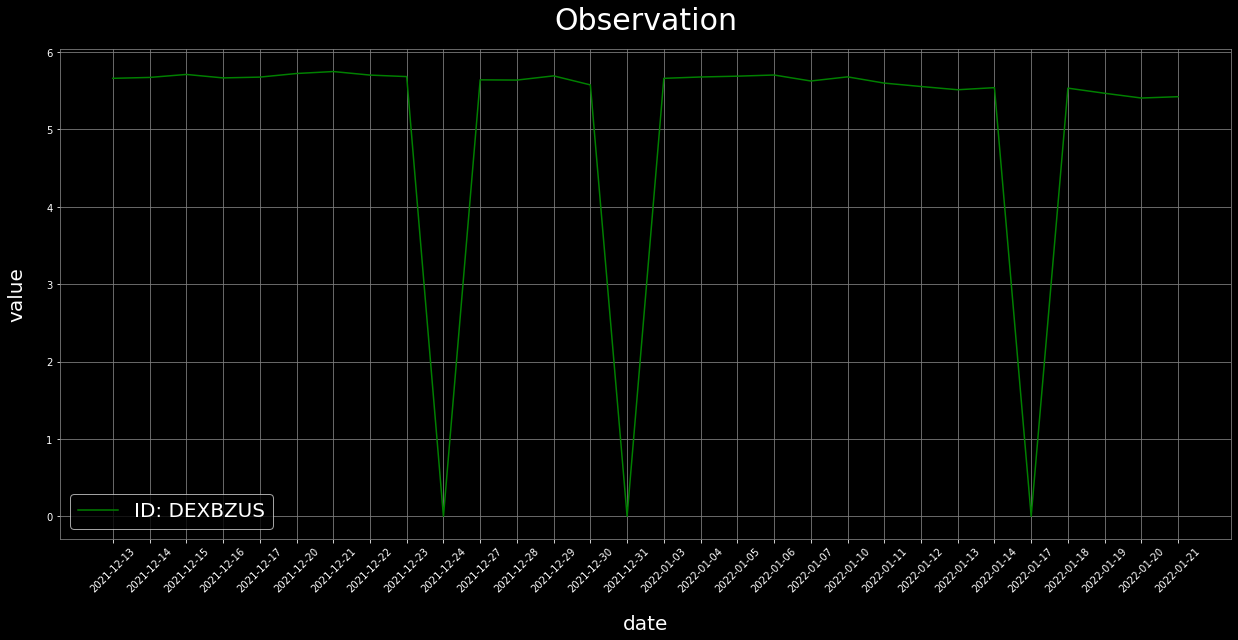

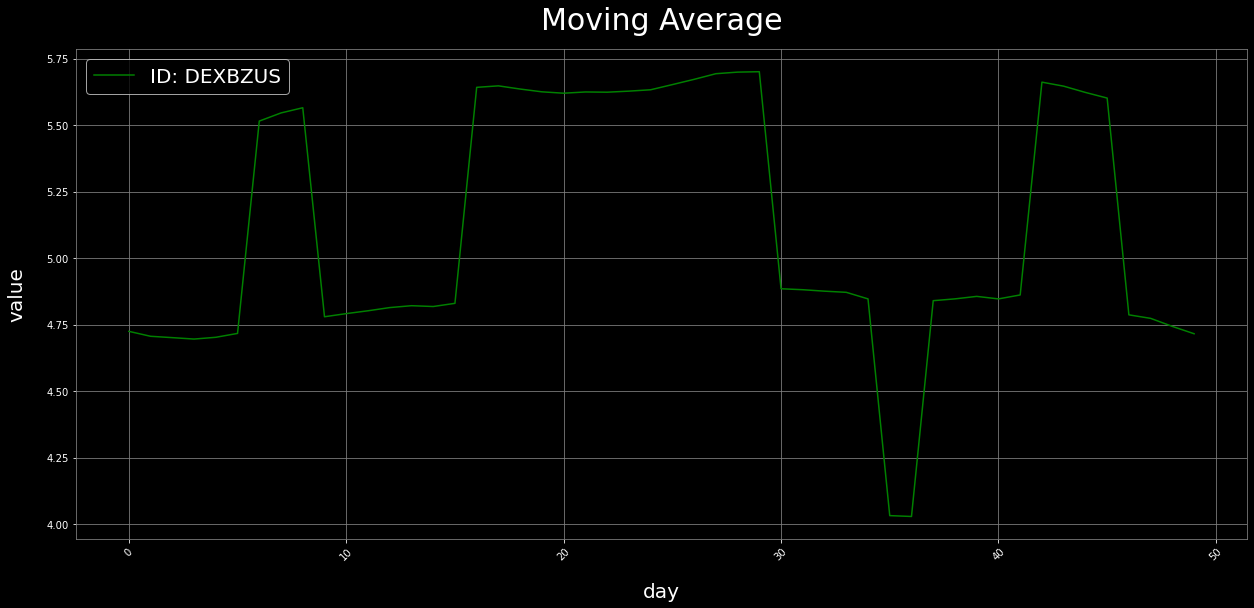

In [4]:
#Graficare l’andamento di una osservabile (se possibile)

grid_color = "grey"
label_color = "white"
plot_color="green"
title_fontsize = 30
axes_fontsize = 20
text_pad = 20
context = {'axes.edgecolor':'grey',
           'axes.facecolor':'black',
           'font.family':'sans-serif', 
           'figure.facecolor':'black', 
           'figure.edgecolor':'black',
           'xtick.color':'white', 
           'ytick.color':'white', 
           'savefig.transparent':'True'}

def convert_string_float(array_string):
    
    array_float = []
    
    for values in array_string:
    
        if values == ".": values = 0
    
        array_float.append(float(values))
    
    return array_float

def display_observation(id):
    
    pd = get_db(DB, "observations", id)
    x = pd['date'].tolist()
    y = pd['value'].tolist()
    y = convert_string_float(y)    
    
    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.plot(x[-30:], y[-30:], color=plot_color, label="ID: " + id)
        
        plt.title("Observation", color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)

        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel("date", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_observation.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
        
        plt.show()

    return plt
        
#Graficare la media mobile (se possibile) di una osservabile a 𝑛 giorni (𝑛 parametro)
def moving_average(input_array, day):
    
    list = convert_string_float(input_array)
    
    ret = []
    window = 0
    
    for i in range(day):
        window += list[i]
        
    for i in range(day, len(list)):
        ret.append(window / day)
        window = window + list[i] - list[i-day]
    
    return ret
    
def display_moving_average(id, day):
    
    pd = get_db(DB, "observations", id)
    x = pd['value'].tolist()    
    ma = moving_average(x, day)
    
    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.plot(ma[-50:], color=plot_color, label="ID: " + id)
        
        plt.title("Moving Average", color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)

        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel("day", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_moving_average.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
        
        plt.show()
    
display_observation(ID_OBSERVATION)
display_moving_average(ID_OBSERVATION, 7)

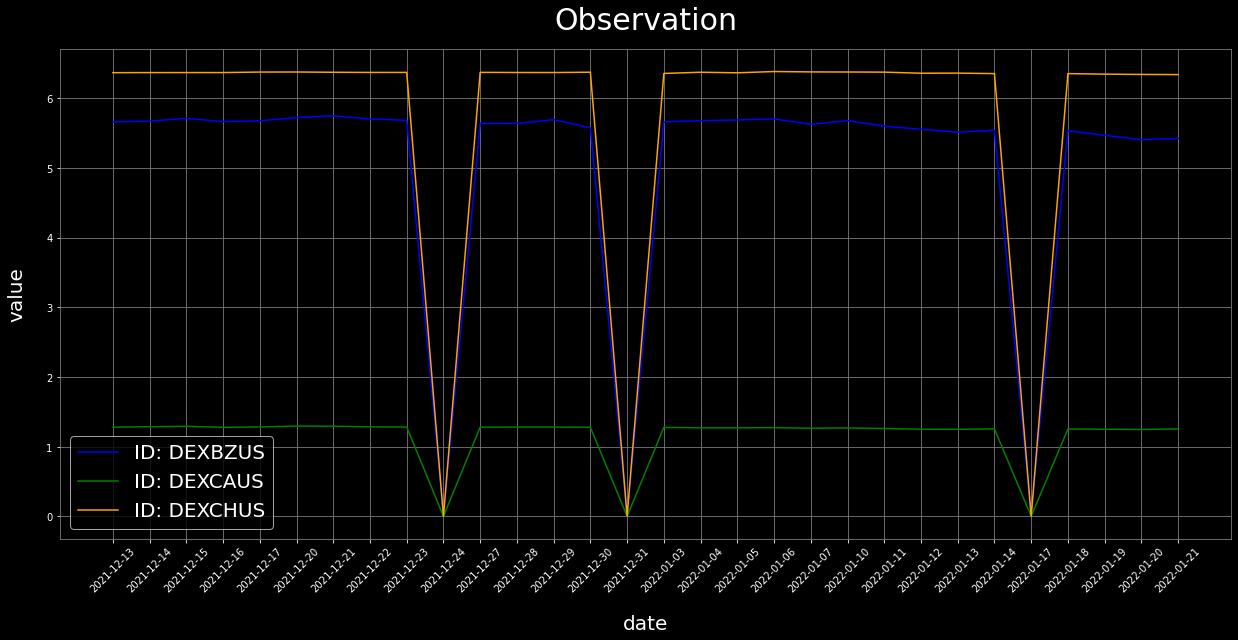

In [58]:
#CASE STUDY (Money, Banking, & Finance > Exchange Rates)
ID_CATEGORY = 94 #Daily Rates

#Scaricare  tutte le serie  da  una  singola categoria (in realtà ne sono sufficienti 3)
#create_db(DB)
#insert_db(DB, ID_CATEGORY, "series", False)
#df = get_db(DB, "seriess", None)
#with pd.option_context('display.max_rows', None,
 #                      'display.max_columns', None,
  #                     'display.precision', 3,
   #                    ):
    #print(df)

#Graficare 3 serie su un solo grafico
ID_SERIES = ["DEXBZUS", "DEXCAUS", "DEXCHUS"]

for index in range(len(ID_SERIES)):
    insert_db(DB, ID_SERIES[index], "observation", False)

if 1 == 1:
    
    a = get_db(DB, "observations", ID_SERIES[0])
    x = a['date'].tolist()
    y = a['value'].tolist()
    y = convert_string_float(y)
    
    a = get_db(DB, "observations", ID_SERIES[1])
    z = a['value'].tolist()
    z = convert_string_float(z)
    
    a = get_db(DB, "observations", ID_SERIES[2])
    k = a['value'].tolist()
    k = convert_string_float(k)
    
    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.title("Observation", color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)
        
        plt.plot(x[-30:], y[-30:], color="blue", label="ID: " + ID_SERIES[0])
        plt.plot(x[-30:], z[-30:], color="green", label="ID: " + ID_SERIES[1])
        plt.plot(x[-30:], k[-30:], color="orange", label="ID: " + ID_SERIES[2])
    
        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel("date", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_observation.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
    
plt.show()